In [181]:
!python -V

Python 3.8.10


In [182]:
!pip install pyarrow seaborn pandas numpy sklearn -q

In [183]:
import pandas as pd
import pickle

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

In [185]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [186]:
def get_dataframe(filename, categorical, homework=False):
    """This function is to get dataframe, in two formats:
    'csv' or 'parquet', in case of csv two colums will transform to
    datatime

    Args:
        filename (str): name of file to read and preprocess
        homework (bool, optional): show results of homework.
            defaults False

    Returns:
        pandas.DataFrame: dataframe with preprocess to create the model
    """
    df = pd.read_parquet(filename)
    if homework is True:
        total_records = df.shape[0]
        print(f"total of records {total_records}")

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    if homework is True:
        avg = df['duration'].mean()
        print(f'The average of duration is {avg}')

        duration_pl = df.groupby(['duration'])['duration'].count()

        sns.displot(duration_pl)
        plt.show()

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    if homework is True:
        new_size_df = total_records - df.shape[0]
        print(f"deleted records of dataframe (1 > x > 60): {new_size_df}")
        # print(df.head(2))

    df[categorical] = df[categorical].fillna("-1")

    if homework is True:
        minus_total_values = df[df['PUlocationID'] == "-1"].shape[0]
        total_values_df = df.shape[0]
        print(f'Total of -1 in PULocationID: {minus_total_values}')
        print(f'Total of records: {total_values_df}')
        percent_missing = (minus_total_values * 100) / total_values_df
        print(f'The percent of missing: {percent_missing}')

    df = df[(df[categorical[0]] != "-1") | (df[categorical[1]] != "-1")]
    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df[categorical[0]] + '_' + df[categorical[1]]

    return df

In [187]:
def vectorize_data(df_train, categorical, numerical, df_val, homework=False):
    """This function is to create a dict vectorized of values from
        dataframes

    Args:
        df_train (pandas.DataFrame): Dataframe to train the model
        df_val (pandas.DataFrame): Dataframe to validate the model
        categorical (list): list of name of columns that is categoricals
        numerical (list): list of name of columns that is numericals

    Returns:
        tuple<DictVectorizer, list, list>: tuple of dictVectorized with
        fit_transform and transform
    """
    dv = DictVectorizer()
    X_val = None

    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)

    if homework is True:
        size = X_train.shape
        print(f'The dimensionality of the matrix is: {size[1]}')

    return dv, X_train, X_val

In [188]:
def train_model(model, X_train, y_train):
    """Function to train the model

    Args:
        model (Sklearn.linear_model.?): Model to train in the linear model package
        X_train (list): List of Values to train the model
        y_train (list): List of results to train the model

    Returns:
        Sklearn.linear_model.?: trained model
    """
    model = model()
    model.fit(X_train, y_train)

    return model

In [189]:
def test_model(model_fit, X_test, y_val):
    """Function to test model, and get the mean_squared_error

    Args:
        model_fit (sklearn.linear_model.?.train): trained model to test
        X_test (list): values to predict
        y_train (list): real values to test

    Returns:
        float: mean squared error
    """
    y_pred = model_fit.predict(X_test)
    error = mean_squared_error(y_val, y_pred, squared=False)

    return error

In [190]:
def save_model(variables, name, mode='wb'):
    """Function to save model

    Args:
        variables (tuple): Tuple of DictVect and trained model
        name (str): name to save model, without extension
            (saved in folder model)
        mode (str, optional): mode of open model, recommend (w or wb).
            Defaults to 'wb'.
    """
    with open(f'models/{name}.bin', mode) as f_out:
        pickle.dump(variables, f_out)

In [191]:
def main(show_homework=True):
    """main function

    Args:
        show_homework (bool, optional): Show the response of homework.
            Defaults to True.
    """
    # Variables to use
    # Categorical_df is because exists diference between green and fhv
    categorical_df = ['PUlocationID', 'DOlocationID']
    categorical = ['PUlocationID', 'DOlocationID'] # ['PU_DO']
    numerical = []
    target = "duration"

    # get dataframes
    # df_train = get_dataframe('./data/green_tripdata_2021-01.parquet')
    # df_val = get_dataframe('./data/green_tripdata_2021-02.parquet')
    df_train = get_dataframe(
        './data/fhv_tripdata_2021-01.parquet', categorical_df, True
    )
    df_val = get_dataframe(
        './data/fhv_tripdata_2021-02.parquet', categorical_df
    )

    # get the vectorizer dict
    dv, X_train, X_val = vectorize_data(
        df_train, categorical, numerical, df_val, True
    )

    y_train = df_train[target].values
    y_val = df_val[target].values

    model = train_model(LinearRegression, X_train, y_train)
    validation_error_self = test_model(model, X_train, y_train)
    validation_error = test_model(model, X_val, y_val)

    print(f'the validation with same DF: {validation_error_self}')
    print(f'the validation with feb: {validation_error}')

    save_model((dv, model), 'steph_LR')

total of records 1154112
The average of duration is 19.167224093791006


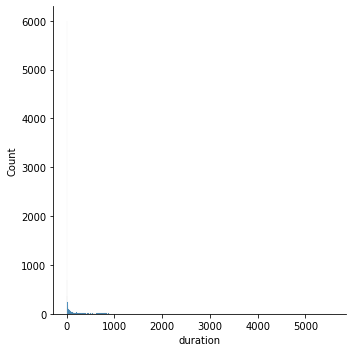

deleted records of dataframe (1 > x > 60): 44286
Total of -1 in PULocationID: 927008
Total of records: 1109826
The percent of missing: 83.52732770722618
The dimensionality of the matrix is: 525
the validation with same DF: 9.97597277945894
the validation with feb: 10.485351412671482


In [192]:
main()
# q1 -> B
# q2 -> B
# Q3 -> D
# Q4 -> D
# Q5 -> B
# Q6 -> B